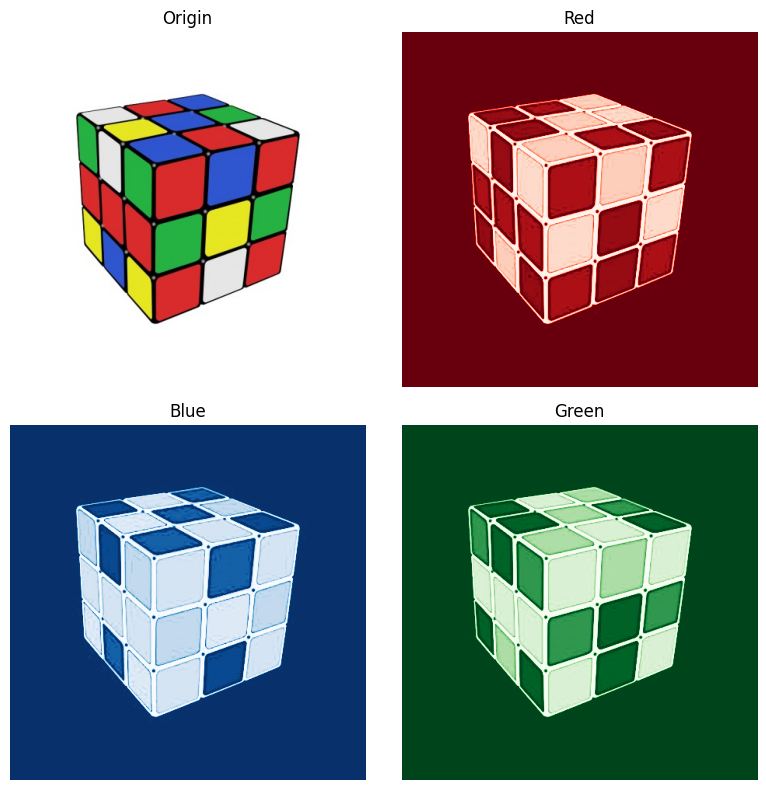

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rng

image = cv2.imread('images/square.jpg')

blue, green, red = cv2.split(image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)


plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Origin')
plt.axis('off')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

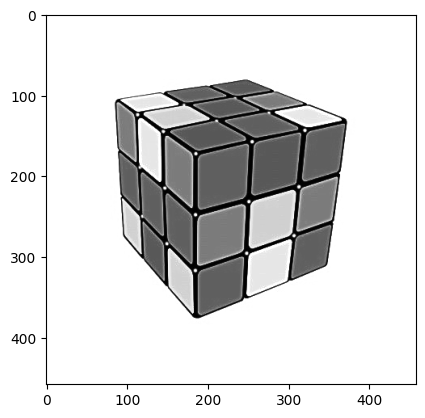

In [23]:
HP_gray_image = cv2.cvtColor(cv2.merge([blue, green, red],), cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
plt.imshow(HP_gray_image,cmap="gray")

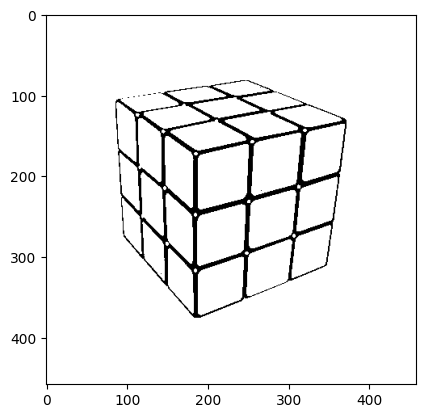

In [24]:
# threshold binario per identificare i bordi delle caselle nel cubo
ret,threshold_image = cv2.threshold(HP_gray_image,80,255,cv2.THRESH_BINARY)
plt.imshow(threshold_image,cmap="gray")

Number of Contours found = 204


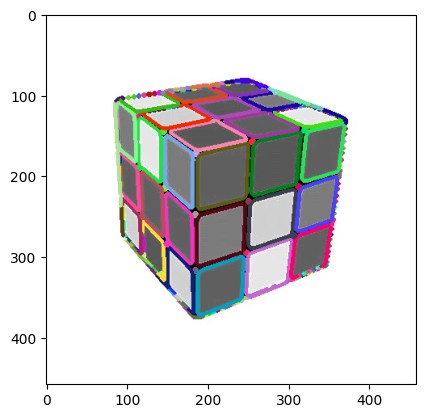

In [29]:
edged = cv2.Canny(threshold_image, 30, 200) 
cv2.waitKey(0) 
contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print("Number of Contours found = " + str(len(contours))) 
# Filtra i contorni in base a Size, Eccentricity e Solidity

HP_gray_image2 = cv2.cvtColor(HP_gray_image,cv2.COLOR_GRAY2RGB)

filtered_contours = []
for i, c in enumerate(contours):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv2.drawContours(HP_gray_image2, contours, i, color, thickness = 3)

# Visualizza l'immagine risultante
plt.imshow(cv2.cvtColor(HP_gray_image2, cv2.COLOR_BGR2RGB))